<img align="center" src="img/course.png" width="800">

# 16720 (B)  Object Tracking in Videos - Assignment 6 - Q3
    Instructor: Kris                          TAs: Arka, Rohan, Rawal, Sheng-Yu, Jinkun


## Q3: Lukas-Kanade on Image Pyramids (Extra Credit, 15 PT)

If the target being tracked moves a lot between frames, the LK tracker can break down. One way to mitigate this problem is to run the LK tracker on a set of image pyramids instead of a single image. The Pyramid tracker starts by performing tracking on a higher level (smaller image) to get a coarse alignment estimate, propagating this down into the lower level and repeating until a fine aligning warp has been found at the lowest level of the pyramid (the original sized image). In addition to being more robust, the pyramid version of the tracker is much faster because it needs to run fewer gradient descent iterations on the full scale image due to its coarse to fine approach. Implement these modifications for the Lucas-Kanade tracker that you implemented for Q1. You may find this [paper](http://robots.stanford.edu/cs223b04/algo_tracking.pdf) useful.

This question will be graded manually.

<span style='color:red'>**Output:**</span> In your write-up: Please include the relevant code and submit the results of your algorithm on either of the videos, compare with the results from the Lucas-Kanade tracker, and explain any differences.


In [1]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [2]:
import torch
device = torch.cuda.is_available()
print('*' * 50)
if torch.cuda.is_available():
    print('CUDA is found! Tranining on %s.......'%torch.cuda.get_device_name(0))
else:
    warnings.warn('CUDA not found! Training may be slow......')

**************************************************
CUDA is found! Tranining on NVIDIA GeForce RTX 3060 Laptop GPU.......


In [3]:
def constructPyramid(im, lvl):
    image_prmd = [image]
    
    for i in range(1, lvl):
        h = pyramid[i - 1].shape[1]
        w = pyramid[i - 1].shape[0]
        
        nh = (h + 1) // 2
        nw = (w + 1) // 2
    
        w_xo = np.arange(1, w, 2)
        
        w_xe = np.arange(0, w, 2)
        
        h_yo = np.arange(1, h, 2)
        
        h_ye = np.arange(0, h, 2)
        
        if w_xe > w_xo:
            w_xe = w_xe[: -1]
        if h_ye > h_yo:
            h_ye = h_ye[: -1]
        
        assert w_xe == w_xo
        assert h_ye == h_yo
        assert w_xe == h_ye
        
        im_i = 0.25 * image_prmd[i - 1][y_e, x_e] + \
            0.125 * (image_prmd[i - 1][y_e, x_o] + image_prmd[i - 1][y_e, x_e] + \
                     image_prmd[i - 1][y_e, x_e] + image_prmd[i - 1][y_e, x_e] )

In [3]:
def LucasKanadePyramidal(It, It1, rect, lvl = 3, thresh=.025, maxIters=100):

    M = np.hstack((np.eye(2), np.zeros(2).reshape(-1, 1)))
    x1, y1, x2, y2 = rect
    
    s1 = np.arange(It.shape[0])
    s2 = np.arange(It.shape[1])
    s3 = np.arange(It1.shape[0])
    s4 = np.arange(It1.shape[1])
    interit = RectBivariateSpline(s1, s2, It) 
    interit1 = RectBivariateSpline(s3, s4, It1)
    
    random_x = np.arange(x1, x2 + 0.5)
    random_y = np.arange(y1, y2 + 0.5)
    x, y = np.meshgrid(random_x, random_y)
    x = x.flatten()
    y = y.flatten()    
    T_ev = interit.ev(y, x)
    
    coords_ = np.hstack((x.reshape(-1, 1), y.reshape(-1, 1)))
        
    for i in range(maxIters):

        coords = M @ (np.hstack((coords_, np.ones(coords_.shape[0]).reshape(-1, 1))).T)
        
        x = coords[0].flatten()
        y = coords[1].flatten()
                
        I_ev = interit1.ev(y, x)

        T_x = interit1.ev(y, x, dx=0, dy=1)
        T_y = interit1.ev(y, x, dx=1, dy=0)

        A = np.zeros((x.shape[0], 6))
        
        A[:, 0] = x * T_x
        A[:, 1] = x * T_y
        A[:, 2] = y * T_x
        A[:, 3] = y * T_y
        A[:, 4] = T_x
        A[:, 5] = T_y

        b = T_ev - I_ev
        
        dp = np.linalg.lstsq(A, b, rcond=None)[0]        
        M = M + dp.reshape(np.flip(M.shape)).T
        
        if np.sqrt(np.sum(dp ** 2)) <= thresh:
            break
    
    return M

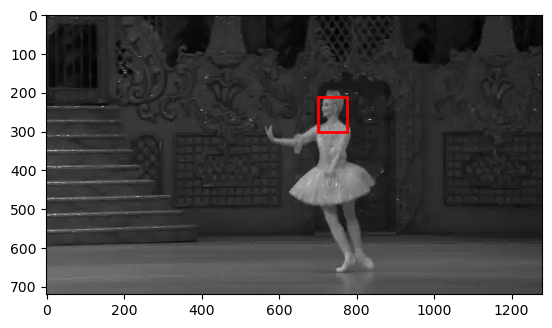

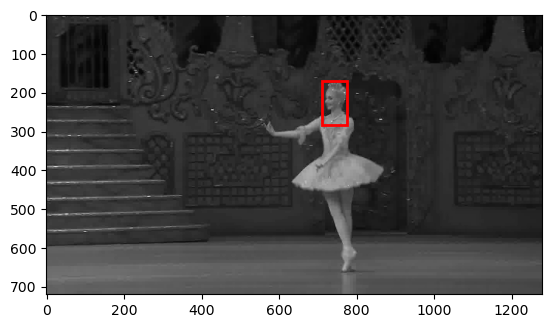

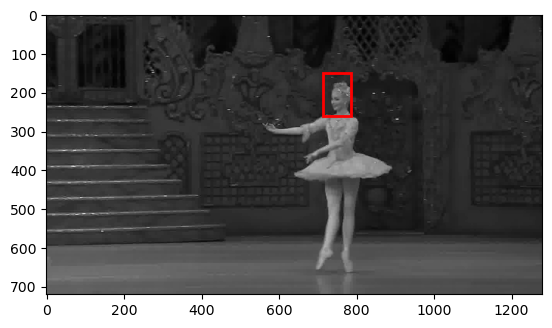

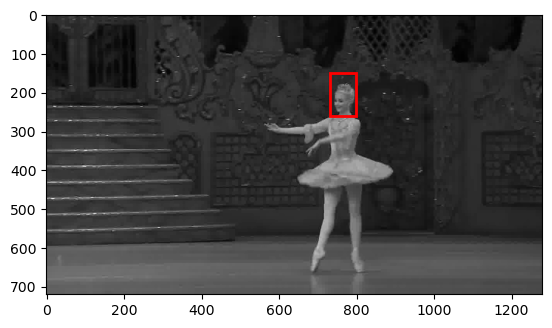

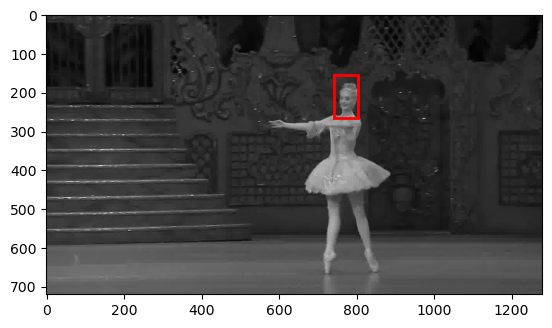

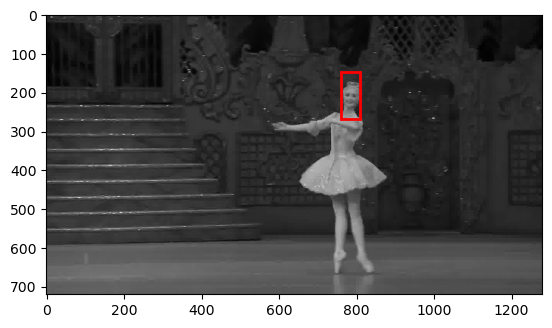

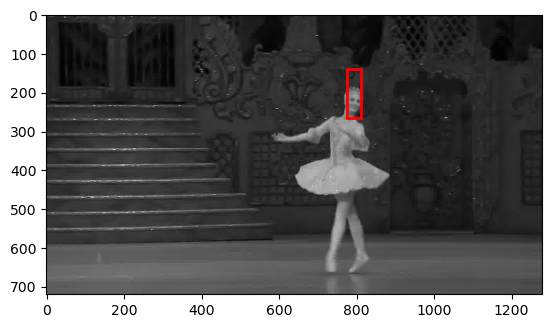

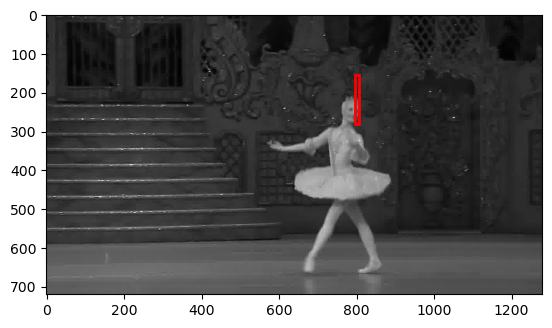

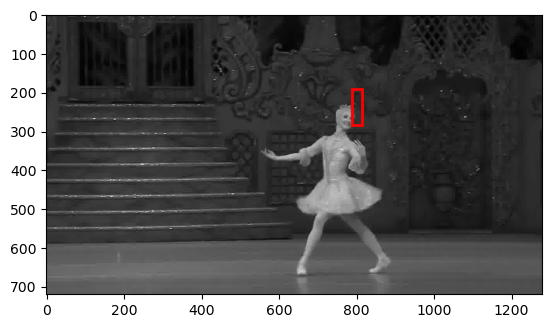

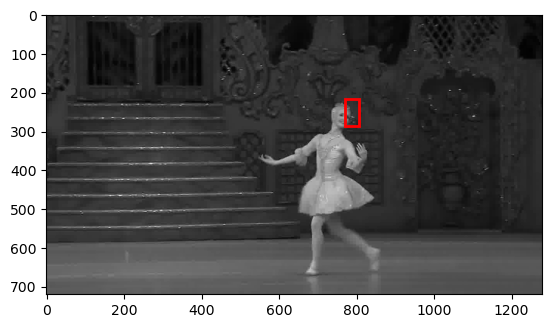

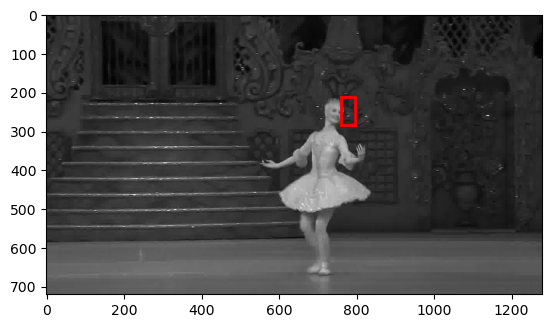

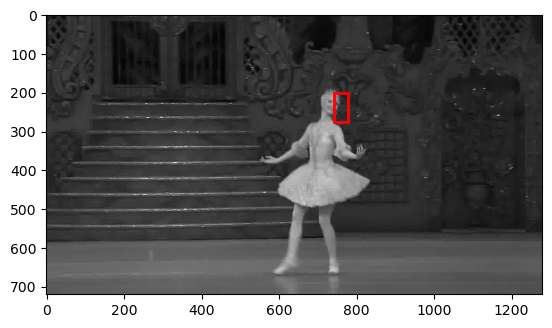

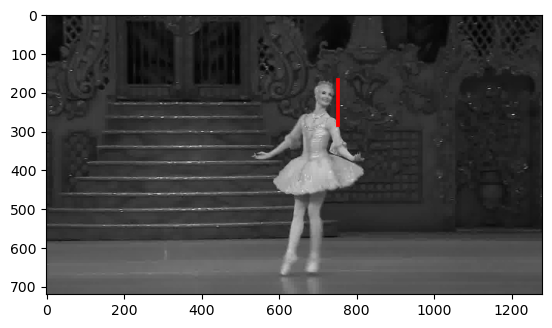

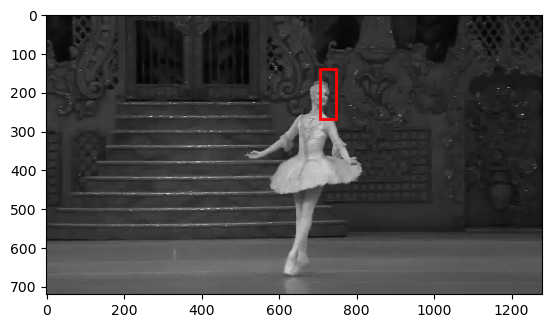

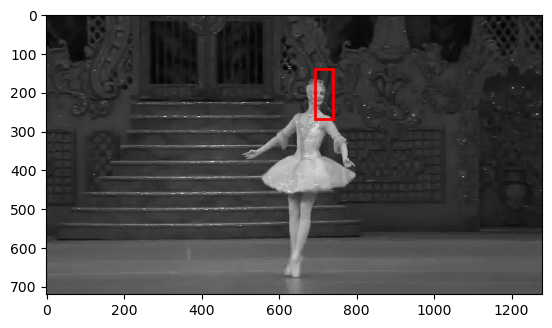

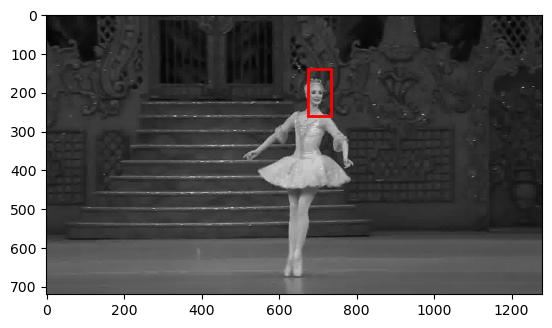

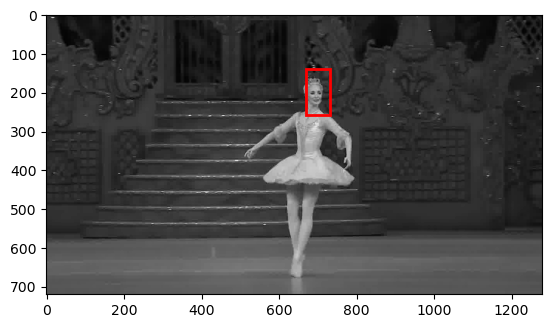

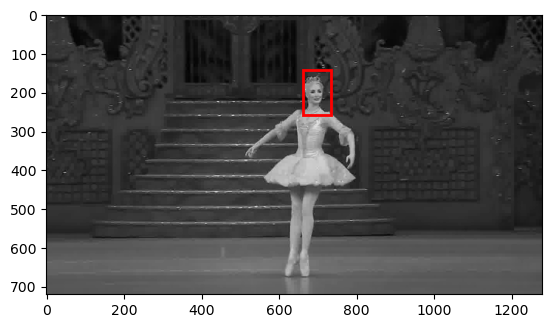

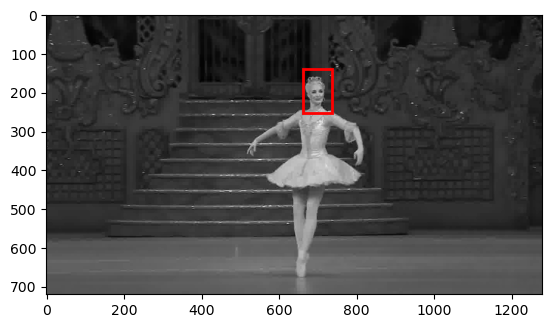

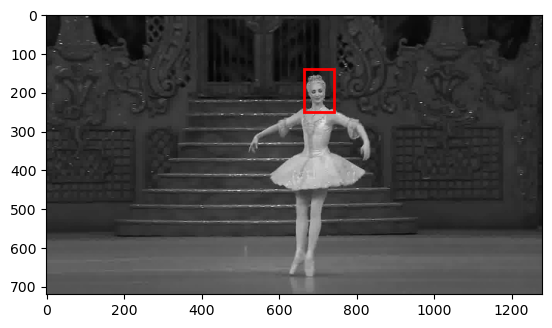

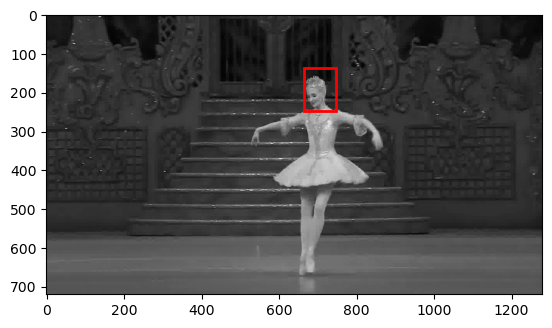

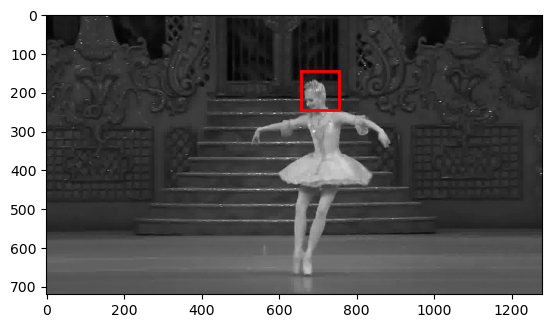

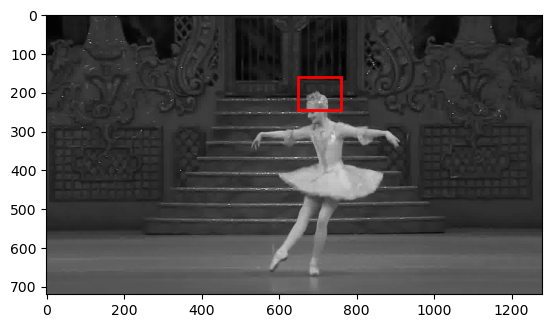

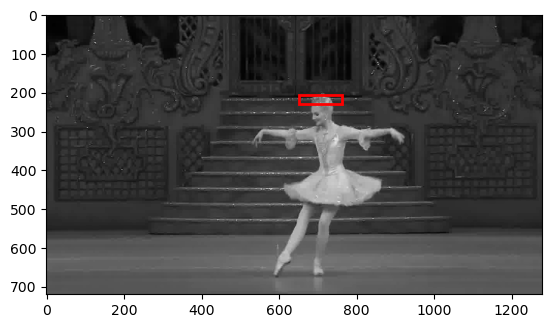

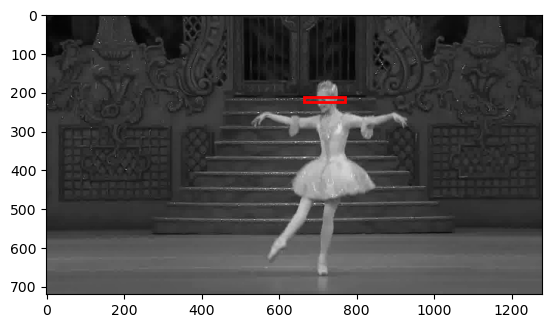

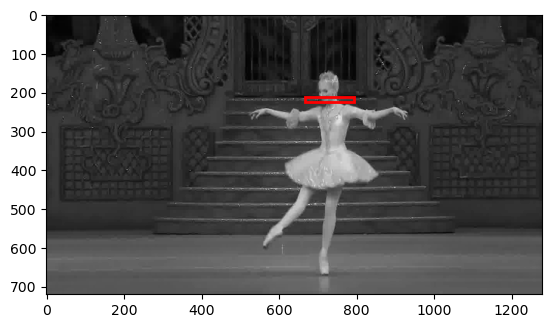

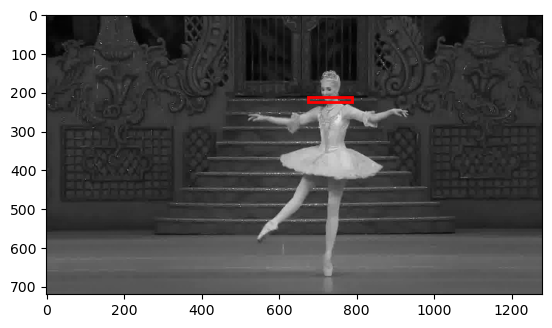

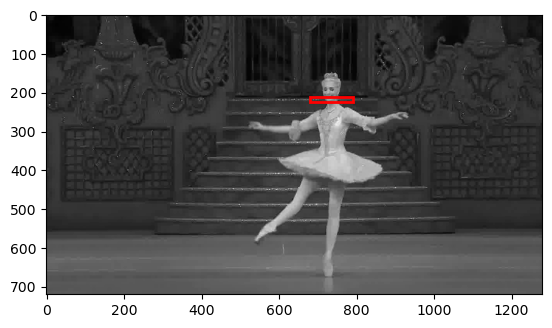

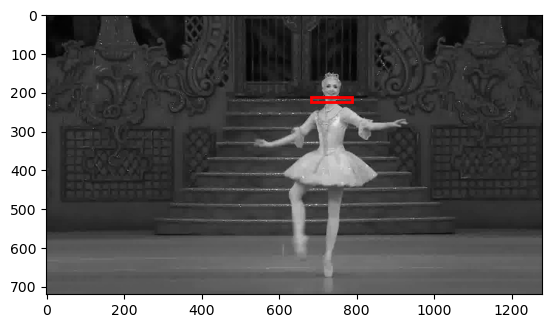

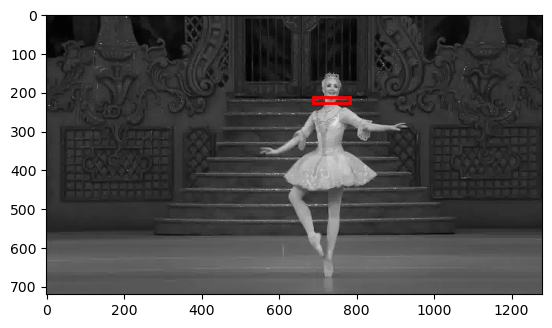

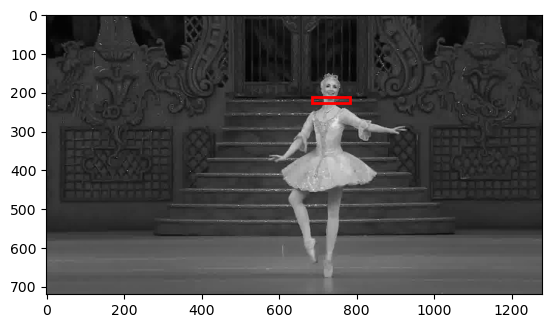

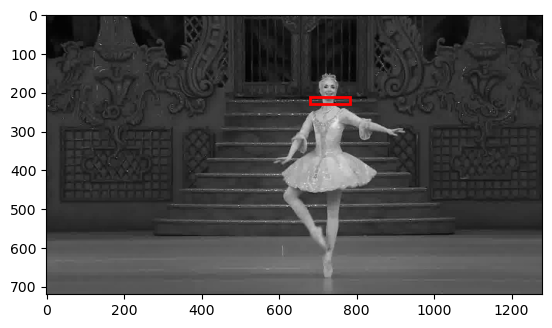

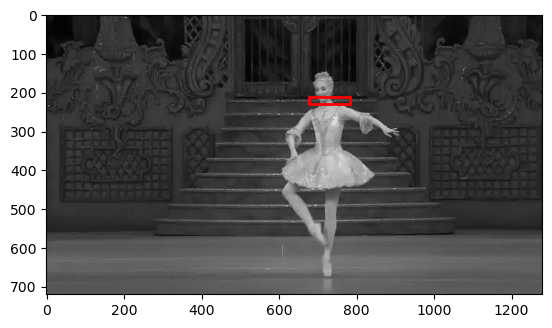

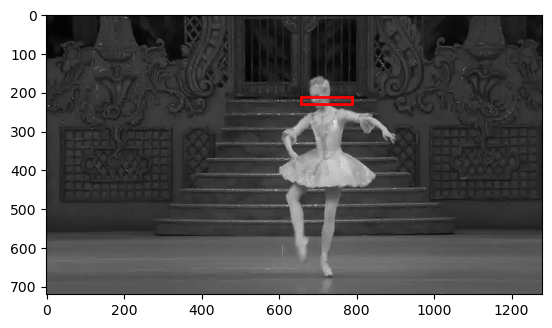

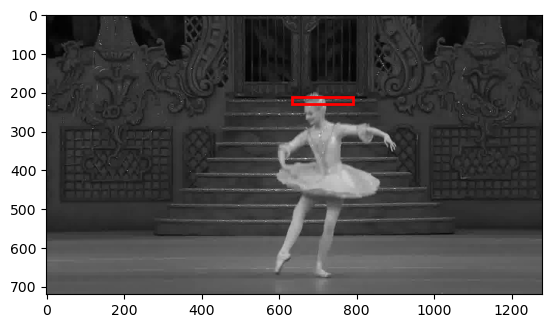

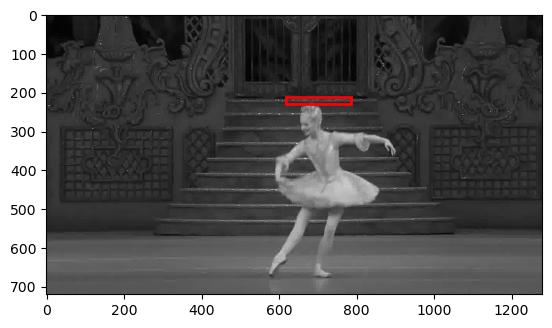

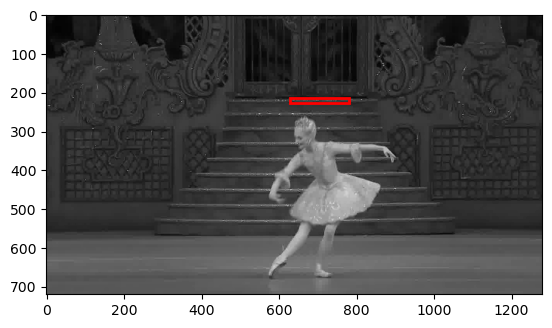

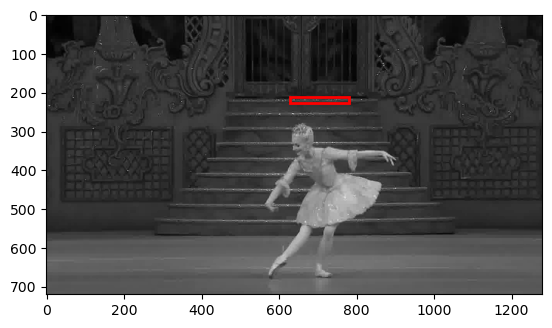

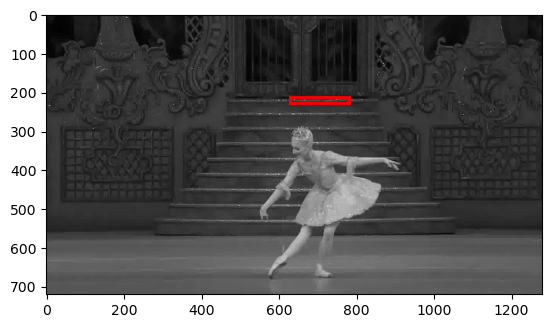

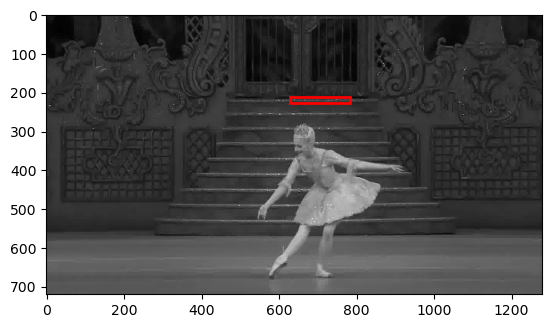

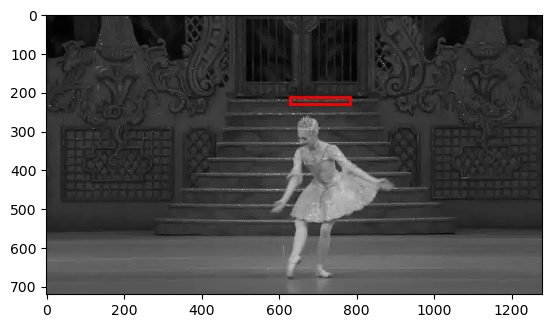

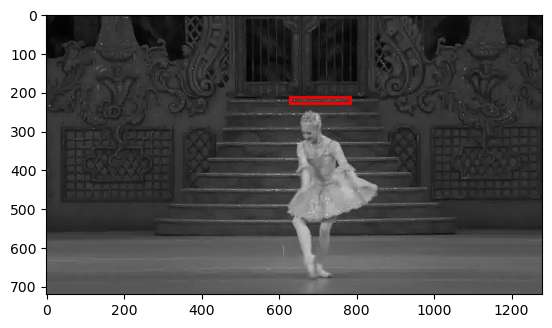

In [4]:
# Test your algorithm and visualize results!

# Load data
data_name = 'ballet' # could choose from (car1, car2, landing, race, ballet)
data = np.load('./data/%s.npy' % data_name)

# obtain the initial rect with format (x1, y1, x2, y2)
if data_name == 'car1':
    initial = np.array([170, 130, 290, 250])   
elif data_name == 'car2':
    initial = np.array([59, 116, 145, 151])    
elif data_name == 'landing':
    initial = np.array([440, 80, 560, 140])     
elif data_name == 'race':
    initial = np.array([170, 270, 300, 370])
elif data_name == 'ballet':
    initial = np.array([700, 210, 775, 300])     
else:
    assert False, 'the data name must be one of (car1, car2, landing, race, ballet)'

numFrames = data.shape[2]
w = initial[2] - initial[0]
h = initial[3] - initial[1]

# loop over frames
rects = []
rects.append(initial)

for i in range(numFrames-1):

    It = data[:,:,i]
    It1 = data[:,:,i+1]
    rect = rects[i]

    # run algorithm and collect rects
    M = LucasKanadePyramidal(It, It1, rect)
    corners = np.array([[rect[0], rect[1], 1], 
                        [rect[2], rect[3], 1]]).transpose()
    newRect = np.matmul(M, corners).transpose().reshape((4, ))
    rects.append(newRect)

    # Visualize
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.add_patch(patches.Rectangle((rect[0], rect[1]), rect[2]-rect[0]+1, rect[3]-rect[1]+1, linewidth=2, edgecolor='red', fill=False))
    plt.imshow(It1, cmap='gray')
    plt.show()
    ax.clear()